In [1]:
%load_ext autoreload
%autoreload 2

import os

import copy

import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table, Column, hstack

from mrf.display import display_single, SEG_CMAP
from IPython.display import clear_output

plt.rcParams['text.usetex'] = True

## Here we use the LSBG-750 from Greco et al. 2018 http://adsabs.harvard.edu/abs/2018ApJ...857..104G. 

In [18]:
obj = {'ra': 179.9315,
       'dec': -0.77272222,
       'Seq': 750}

In [19]:
from mrf.download import download_decals_cutout
# We make a Sersic kernel
from astropy.modeling.functional_models import Sersic2D, Gaussian2D
from astropy.convolution import convolve_fft
from mrf.celestial import Celestial

### Download DECaLS and HSC images

In [20]:
ra, dec = obj['ra'], obj['dec']
cutout_size = 3000 # pix for DECaLS
download_decals_cutout(ra, dec, cutout_size, 'r', pixel_unit=True, 
                       output_dir='DECaLS_cutout/', output_name='DECaLS_{:03d}'.format(obj['Seq']))
download_decals_cutout(ra, dec, cutout_size, 'g', pixel_unit=True, 
                       output_dir='DECaLS_cutout/', output_name='DECaLS_{:03d}'.format(obj['Seq']))
clear_output()

In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from unagi.hsc import Hsc
from unagi.task import hsc_cutout
pdr2 = Hsc(dr='pdr2', rerun='pdr2_wide')

cutout_size = 3000 # pix for DECaLS

hsc_cutout(SkyCoord(ra, dec, unit='deg'), cutout_size=cutout_size * 0.262 * u.arcsec / 2, 
           filters='r', archive=pdr2, save_output=True, 
           output_dir='./HSC_cutout/', prefix='HSC_{:03d}'.format(obj['Seq']));

hsc_cutout(SkyCoord(ra, dec, unit='deg'), cutout_size=cutout_size * 0.262 * u.arcsec / 2, 
           filters='g', archive=pdr2, save_output=True, 
           output_dir='./HSC_cutout/', prefix='HSC_{:03d}'.format(obj['Seq']));

### Make low-resolution images based on HSC ones

In [42]:
for filt in ['g', 'r']:
    hdu = fits.open('./HSC_cutout/HSC_{0:03d}_{1}.fits'.format(obj['Seq'], filt))
    hires = Celestial(hdu[1].data, header=hdu[1].header)
    hdu.close()

    size = 200
    #m_sersic = Gaussian2D(amplitude=1, x_mean=size, y_mean=size, x_stddev=10, y_stddev=10)
    m_sersic = Sersic2D(r_eff=15, n=0.95, x_0=size, y_0=size)
    y, x = np.mgrid[:(size * 2 + 1), :(size * 2 + 1)]
    sersic_kernel = m_sersic(x, y)
    sersic_kernel /= np.sum(sersic_kernel) # normalize
    fakeDF = convolve_fft(hires.image, kernel=sersic_kernel, allow_huge=True)
    hires.image = fakeDF
    hires.resize_image(hires.pixel_scale / 2.5, method='iraf')
    hires.save_to_fits('./HSC_cutout/LSBG_{0:03d}_lowres_{1}.fits'.format(obj['Seq'], filt))

In [23]:
from mrf.celestial import Celestial
from astropy.convolution import convolve, Gaussian2DKernel

for filt in ['g', 'r']:
    hdu = fits.open('DECaLS_cutout/DECaLS_{0:03d}_{1}.fits'.format(obj['Seq'], filt))
    hires = Celestial(hdu[0].data, header=hdu[0].header)
    hdu.close()
    hires.resize_image(0.5, method='iraf')
    hires.image = convolve(hires.image, Gaussian2DKernel(1))
    hires.save_to_fits('./DECaLS_cutout/LSBG_{0:03d}_hires_{1}_bin.fits'.format(obj['Seq'], filt))

In [43]:
from mrf.task import MrfTask
task = MrfTask('LSBG-task-cross-g.yaml')
img_lowres = './HSC_cutout/LSBG_{0:03d}_lowres_{1}.fits'.format(obj['Seq'], 'g')
img_hires_b = './DECaLS_cutout/LSBG_{0:03d}_hires_{1}_bin.fits'.format(obj['Seq'], 'g')
img_hires_r = './DECaLS_cutout/LSBG_{0:03d}_hires_{1}_bin.fits'.format(obj['Seq'], 'r')
certain_gal_cat = None
results = task.run(img_lowres, img_hires_b, img_hires_r, certain_gal_cat, 
                   output_name='LSBG_g_{:03d}'.format(obj['Seq']), verbose=True)

2019-10-22 01:11:36,725 Running Multi-Resolution Filtering (MRF) on "DECaLS" and "HSC" images!
2019-10-22 01:11:36,748 Magnify Dragonfly image with a factor of 3.0:
2019-10-22 01:11:36,927 Register high resolution image "./DECaLS_cutout/LSBG_750_hires_g_bin.fits" with "./HSC_cutout/LSBG_750_lowres_g.fits"
2019-10-22 01:11:37,357 Register high resolution image "./DECaLS_cutout/LSBG_750_hires_r_bin.fits" with "./HSC_cutout/LSBG_750_lowres_g.fits"
2019-10-22 01:11:37,832 Build flux models on high-resolution images: Blue band
2019-10-22 01:11:37,832     - sigma = 3.0, minarea = 2
2019-10-22 01:11:37,833     - deblend_cont = 0.00100, deblend_nthres = 32.0
2019-10-22 01:11:38,004     - Detect 2001 objects
2019-10-22 01:11:38,398 Build flux models on high-resolution images: Red band
2019-10-22 01:11:38,399     - sigma = 3.0, minarea = 2
2019-10-22 01:11:38,400     - deblend_cont = 0.00100, deblend_nthres = 32.0
2019-10-22 01:11:38,581     - Detect 1933 objects
2019-10-22 01:11:38,951 Make col

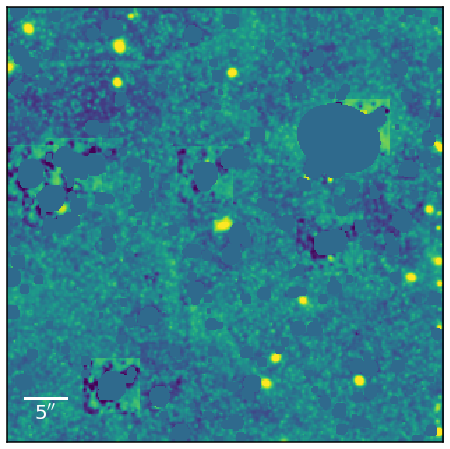

In [48]:
# adjust mask
from mrf.utils import adjust_mask
results = adjust_mask(results, gaussian_threshold=0.01, bright_lim=15, r=5)

## Demo the results

In [49]:
from mrf.utils import img_cutout
ra, dec = 179.9315, -0.77272222

In [55]:
hdu = fits.open('./LSBG_g_750_final.fits')
mrf_g = img_cutout(hdu[0].data, wcs.WCS(hdu[0].header), ra, dec, size=250, prefix='mrf_g')
hdu.close()

hdu = fits.open('./DECaLS_cutout/DECaLS_750_g.fits')
decals_g = img_cutout(hdu[0].data, wcs.WCS(hdu[0].header), ra, dec, 
                      pixel_scale=0.262, size=250, prefix='decals_g')
hdu.close()

hdu = fits.open('./HSC_cutout/LSBG_750_lowres_g.fits')
lowres_g = img_cutout(hdu[0].data, wcs.WCS(hdu[0].header), ra, dec, 
                      pixel_scale=2.5, size=250, prefix='lowres_g')
hdu.close()

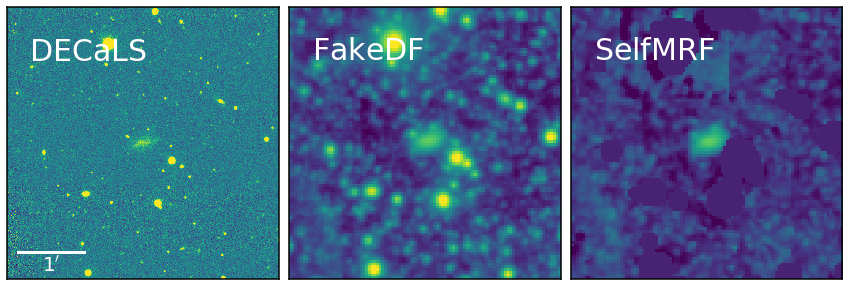

In [54]:
from mrf.display import display_multiple
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 5))
ax1 = display_single(decals_g[0].data, ax=ax1, add_text='DECaLS', 
                     pixel_scale=0.262, scale_bar_length=61, scale_bar_y_offset=0.25)
display_multiple([lowres_g[0].data, mrf_g[0].data], ax=[ax2, ax3], text=['FakeDF', 'SelfMRF'], scale_bar=False)

plt.subplots_adjust(wspace=0.03)

#plt.savefig('LSBG-750-self-mrf.png', bbox_inches='tight')